In [1]:
##############################################
# FEATURE ENGINEERING & DATA PRE-PROCESSING
##############################################


import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

#! =pip install missingno:missingno eksik veri (missing values) görselleştirmesi için hızlı, kullanışlı bir araçtır.

import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


In [2]:
def load():
    data = pd.read_csv("dataset/heart.csv")
    return data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# 1. VERİ YÜKLEME VE EDA FONKSİYONU
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("\n##################### Types #####################")
    print(dataframe.dtypes)
    print("\n##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    print("\n##################### Descriptive Stats #####################")
    print(dataframe.describe([0.05, 0.50, 0.95, 0.99]).T)

# 2. DEĞİŞKEN TÜRLERİNİ AYIRMA (İsviçre Çakısı)
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}, Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}, num_cols: {len(num_cols)}, cat_but_car: {len(cat_but_car)}')
    return cat_cols, num_cols, cat_but_car

# 3. KLİNİK TEMİZLİK VE EKSİKLİK ANALİZİ
def clinical_preprocessing(df):
    df = df.copy()
    
    # Tıbbi hataları (0) NaN yap
    df.loc[df["RestingBP"] == 0, "RestingBP"] = np.nan
    df.loc[df["Cholesterol"] == 0, "Cholesterol"] = np.nan
    
    # Eksiklik Bayrakları (MNAR - Eksikliğin kendisi bir bilgidir)
    df["BP_is_missing"] = df["RestingBP"].isnull().astype(int)
    df["Chol_is_missing"] = df["Cholesterol"].isnull().astype(int)
    df["Oldpeak_is_negative"] = (df["Oldpeak"] < 0).astype(int)
    
    return df

# --- ANA AKIŞ (PIPELINE) ---

# A. Veriyi Al ve İlk Bakış
df = load()
check_df(df)

# B. Klinik Temizlik ve Bayraklama
df = clinical_preprocessing(df)

# C. Profesyonel Veri Doldurma (Iterative Imputer)
# Sadece sayısal sütunlarda diğer değişkenleri kullanarak tahmin yapar
num_cols_for_impute = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
it_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10), random_state=42)
df[num_cols_for_impute] = it_imputer.fit_transform(df[num_cols_for_impute])

# D. Değişkenleri Grupla
cat_cols, num_cols, cat_but_car = grab_col_names(df)

# E. Çarpıklık (Skewness) Kontrolü
print("\n##################### Skewness Analysis #####################")
print(df[num_cols].skew().sort_values(ascending=False))

# F. Görselleştirme (Opsiyonel)
# 
# sns.histplot(df['Cholesterol'], kde=True)
# plt.show()

print("\nVeri seti modelleme için hazır!")

##################### Shape #####################
(918, 12)

##################### Types #####################
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

##################### Missing Values #####################
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

##################### Descriptive Stats #####################
               count    mean     std    min      5%     50%     95%     99%     max
Age          918.000  53.511   9.433 28.000  37.000  54.000  68.000  74.000  77.000
RestingBP    918.00

C:\Users\VICTUS\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


##################### Model Success #####################
Accuracy: 0.8267
F1-Score: 0.8429
ROC-AUC: 0.9041


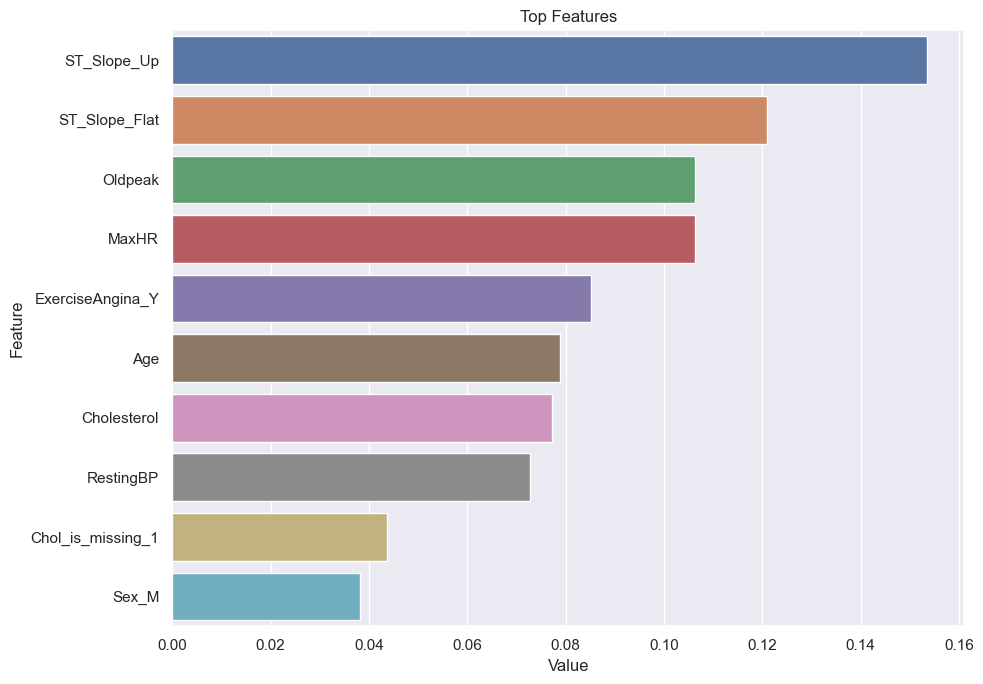

In [4]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. ENCODING (Kategorik Değişkenleri Sayısallaştırma)
# cat_cols listesini grab_col_names ile almıştık. 
# Target değişkenini (HeartDisease) encoding listesinden çıkarıyoruz.
binary_cols = [col for col in cat_cols if df[col].nunique() == 2 and col not in ["HeartDisease"]]
ohe_cols = [col for col in cat_cols if df[col].nunique() > 2]

# Get_dummies ile One-Hot Encoding (drop_first=True ile kukla değişken tuzağından kaçınıyoruz)
df_final = pd.get_dummies(df, columns=ohe_cols + binary_cols, drop_first=True)

# 2. X ve y AYRIMI
y = df_final["HeartDisease"]
X = df_final.drop("HeartDisease", axis=1)

# 3. MODEL KURULUMU (Random Forest)
# Neden Random Forest? Aykırı değerlere dirençlidir ve Feature Importance verir.
rf_model = RandomForestClassifier(random_state=42)

# 4. CROSS VALIDATION (Modelin başarısını doğrula)
# Sadece tek bir teste güvenmiyoruz, veriyi 5'e bölüp test ediyoruz.
cv_results = cross_validate(rf_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

print("##################### Model Success #####################")
print(f"Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"F1-Score: {cv_results['test_f1'].mean():.4f}")
print(f"ROC-AUC: {cv_results['test_roc_auc'].mean():.4f}")

# 5. FEATURE IMPORTANCE (Modelin Kalbi)
rf_model.fit(X, y) # Tüm veriyle eğitip önemli özellikleri bulalım

def plot_importance(model, features, num=10):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title('Top Features')
    plt.tight_layout()
    plt.show()

plot_importance(rf_model, X)

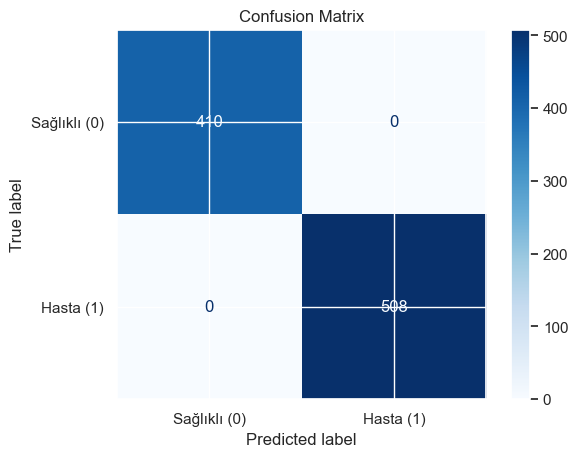

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tahminleri al
y_pred = rf_model.predict(X)

# Hata matrisini hesapla
cm = confusion_matrix(y, y_pred)

# Görselleştir
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sağlıklı (0)", "Hasta (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
##################################